In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import ourfunctions

from matplotlib import pyplot as plt
import seaborn as sns
#from sklearnex import patch_sklearn
#patch_sklearn(verbose=False)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from xgboost import XGBRegressor
from sklearn import svm
from catboost import CatBoostClassifier

In [2]:
X = pd.read_csv('data/Training-set-values.csv')
y = pd.read_csv('data/Training-set-labels.csv')

X['date_recorded'] = pd.to_datetime(X['date_recorded']).astype(np.int64)

#### Preprocessors

In [3]:
# Super basic numeric transformer

numeric_transformer = Pipeline(
    steps=[('imputer', SimpleImputer(strategy='median'))]
)

numeric_preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, make_column_selector(dtype_include=np.number)),
    ]
)

### Models

In [16]:
# kNearestNeighbors
kNN = {'classifier': KNeighborsClassifier(n_jobs=3), 'preprocessor': None}

# Logistic Regressoion
log_reg_basic = {'classifier': LogisticRegression(C=1e6, n_jobs=3), 'preprocessor': None}

# Decision Trees
DecisionTrees = {'classifier': DecisionTreeClassifier(),'preprocessor': None}
# Decision Trees - adjusted
DecisionTreesAd = {'classifier': DecisionTreeClassifier(criterion=['gini','entropy'], max_depth=[90,100], min_samples_split=[2,3], class_weight=['balaced']),'preprocessor': numeric_preprocessor}

# Random Forest with numeric processor
RandomFM_basic = {'classifier': RandomForestClassifier(max_depth=20, min_samples_split=4, n_jobs=3), 'preprocessor': numeric_preprocessor}
# Random Forest no processor
RandomFM_all_cols = {'classifier': RandomForestClassifier(max_depth=20, min_samples_split=4, n_jobs=3), 'preprocessor': None}
# Random Forest default
# Included for RandomCVSearch later on
RandomFM_default = {'classifier': RandomForestClassifier(n_jobs=3), 'preprocessor': None}

# Adaptive Boosting
AdaBoost = {'classifier': AdaBoostClassifier(), 'preprocessor': numeric_preprocessor}
# Gradient Boost
GradBoost = {'classifier': GradientBoostingClassifier(),'preprocessor': numeric_preprocessor}
# XGradient Boosting
XGBoost = {'classifier': XGBRegressor(objective='reg:squarederror'), 'preprocessor': numeric_preprocessor}
# CatBoost
CatBoost = {'classifier': CatBoostClassifier(max_depth=3),'preprocessor': numeric_preprocessor}
# HistBoost
HistBoost = {'classifier': HistBoostClassifier(max_depth=3),'preprocessor': numeric_preprocessor}

# Support Vector Machine
SVM = {'classifier': svm.SVC(),'preprocessor': numeric_preprocessor}

models = {'kNN': kNN,
    'log_reg_basic': log_reg_basic,
    'DecisionTrees': DecisionTrees,
    'DecisionTreesAd': DecisionTreesAd,
    'RandomFM_basic': RandomFM_basic,
    'RandomFM_all_cols': RandomFM_all_cols,
    'RandomFM_default': RandomFM_default,
    'AdaBoost': AdaBoost,
    'GradBoost': GradBoost,
    'XGBoost': XGBoost,
    'CatBoost': CatBoost
    "SVM": SVM
    }


### Modeler

In [17]:
model_run = ourfunctions.Modeler(models, X=X, y=y)

# after the model_run object is created so we can add onto the default preprocessor.
log_reg_regularized = {'classifier': LogisticRegression(n_jobs=3), 'preprocessor': model_run.create_default_prep(num_add=[('scaling', StandardScaler())])}
model_run.add_model('log_reg_regularized', log_reg_regularized)

### Search parameters and kwargs

In [18]:
kNN_params = dict(leaf_size=[1,50],
                    n_neighbors=[1,30], 
                    p=[1,2])
                    
LogRegRCV_params = dict(penalty=['l1', 'l2', 'elasticnet'],
                        C=stats.uniform(loc=1, scale=10),
                        max_iter=list(range(100,400)))

DecisionTree_params = dict(criterion=['gini', 'entropy'],
                        max_depth = list(range(20,50)),
                        min_samples_split = list(range(2, 10)))

RandForestRCV_params = dict(n_estimators=list(range(100,300)),
                            criterion=['gini', 'entropy'],
                            max_depth = list(range(20,50)),
                            min_samples_split = list(range(2, 10)))

GradBoost_params = dict(n_estimators=list(range(100, 400)),
                    criterion=['friedman_mse', 'squared_error'],
                    max_depth=list(range(2, 10)),
                    min_samples_split=list(range(2, 10)),
                    min_samples_leaf=list(range(1, 10)),
                    learning_rate=stats.uniform(loc=0.01, scale=1))

XGBoost_params = dict(learning_rate =stats.uniform(loc=0.1, scale=0.1),
                    n_estimators=list(range(100,1200)),
                    max_depth=list(range(4,30)))

CatBoost_params = dict(max_depth =[3,4,5],
                         n_estimators = [100,200,300])

SVM_params = dict(C=[0.1,1, 10, 100],
                gamma=[1,0.1,0.01,0.001],
                kernel=['rbf', 'poly', 'sigmoid'])

search_options = {'n_jobs': 3, 'random_state': 9280210, 'n_iter': 20}

## RandomizedSearchCV

In [32]:
model_run.hyper_search('log_reg_regularized', params=LogRegRCV_params, searcher_kwargs=search_options, set_to_train=True)

In [24]:
model_run.hyper_search('RandomFM_default', params=RandForestRCV_params, searcher_kwargs=search_options, set_to_train=True)

In [19]:
model_run.hyper_search('kNN', params=kNN_params, searcher_kwargs=search_options, set_to_train=True)

/Users/valeriaviscarra/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/valeriaviscarra/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [20]:
model_run.hyper_search('GradBoost', params=GradBoost_params, searcher_kwargs=search_options, set_to_train=True)

In [21]:
model_run.hyper_search('XGBoost', params=XGBoost_params, searcher_kwargs=search_options, set_to_train=True)

/Users/valeriaviscarra/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [22]:
#model_run.hyper_search('SVM', params=SVM_params, searcher_kwargs=search_options, set_to_train=True)

In [23]:
GradBoost2 = {'classifier': GradientBoostingClassifier(),'preprocessor': None}
model_run.add_model('Grad2', GradBoost2)
model_run.hyper_search('Grad2', params=GradBoost_params, searcher_kwargs=search_options, set_to_train=True)

KeyboardInterrupt: 

In [ ]:
#GradBoost3 = {'classifier': GradientBoostingClassifier(),'preprocessor': None}
#model_run.add_model('Grad3', GradBoost3)

In [ ]:
#GradBoost3_params = dict(n_estimators=list(range(200, 1000)),
#                    criterion=['friedman_mse', 'squared_error'],
#                    max_depth=list(range(2, 10)),
#                    min_samples_split=list(range(2, 10)),
#                    min_samples_leaf=list(range(1, 10)),
#                    learning_rate=stats.uniform(loc=0.001, scale=1))

#model_run.hyper_search('Grad3', params=GradBoost3_params, searcher_kwargs=search_options, set_to_train=True)

In [37]:
model_run.train_model('log_reg_basic')

root - INFO - log_reg_basic has been fit.
root - INFO - Cross validate scores for log_reg_basic: [0.54242424 0.54242424 0.54242424 0.54253648 0.54242424]


## Removing Models

In [26]:
model_run.remove_model('DecisionTrees')


In [27]:
model_run.remove_model('RandomFM_all_cols')
model_run.remove_model('AdaBoost')
model_run.remove_model('XGBoost')
model_run.remove_model('CatBoost')
model_run.remove_model("SVM")


In [29]:
model_run.remove_model('DecisionTreesAd')

In [30]:
model_run.train_model('RandomFM_basic', cv=False)

root - INFO - RandomFM_basic has been fit.


In [33]:
model_run.remove_model('Grad2')

## Test Models

In [36]:
model_run._models

{'kNN': {'classifier': KNeighborsClassifier(n_jobs=3),
  'preprocessor': ColumnTransformer(transformers=[('numeric',
                                   Pipeline(steps=[('imputer',
                                                    SimpleImputer(strategy='median'))]),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7feb11628e50>),
                                  ('categorical',
                                   Pipeline(steps=[('imputer',
                                                    SimpleImputer(fill_value='Missing',
                                                                  strategy='constant')),
                                                   ('casting',
                                                    FunctionTransformer(func=<function Modeler.create_default_prep.<locals>.to_object at 0x7feb381d18b0>)),
                                                   ('one_hot_encode',
                               

In [38]:
model_run.test_all()

## Plotting

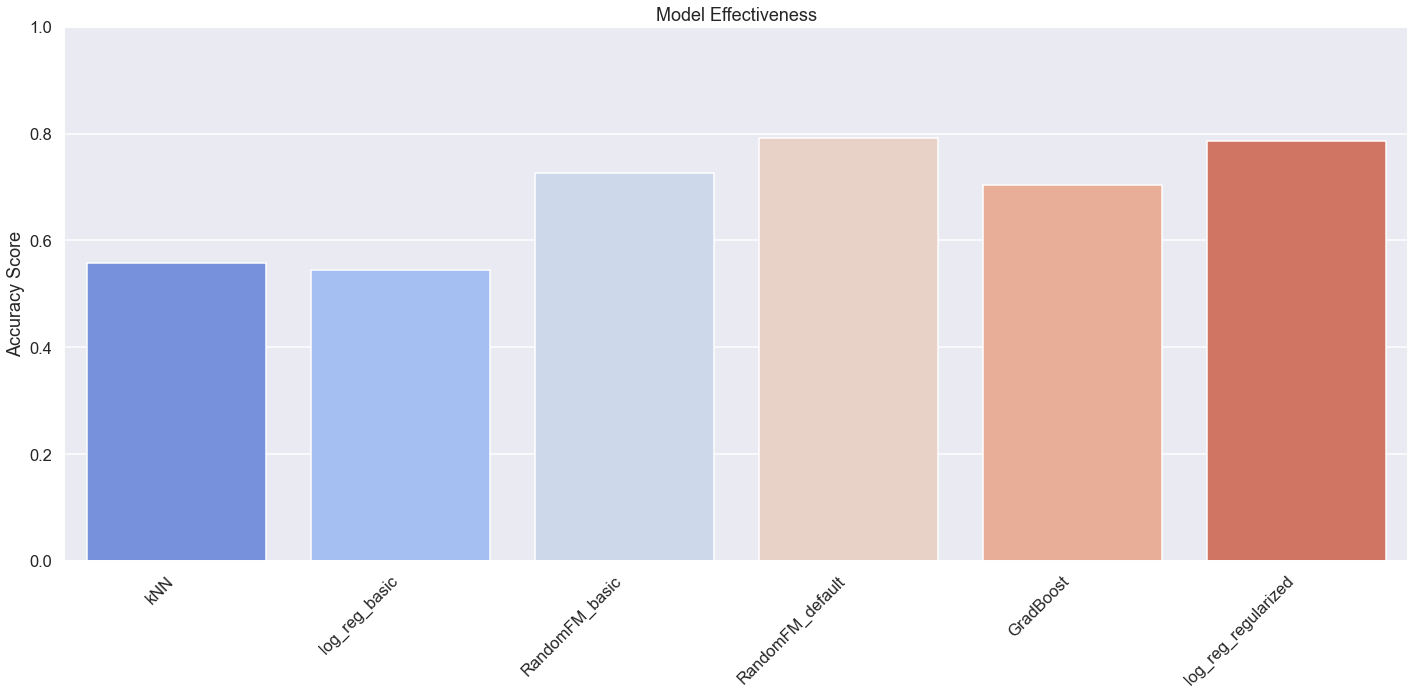

In [39]:
model_run.plot_models(save='thursday_morn_models_graph')